In [ ]:
import uproot
import numpy as np
import pandas as pd

infile = "/Volumes/T7/LHAASO_Monopole/Filt_Event/Dataset_Filted/Proton_all_energies.root"
tree_name = "ntuple"

f = uproot.open(infile)
tree = f[tree_name]

# ---- 读入所有分支 ----
data = tree.arrays(library="pd")

N = len(data)
print("Total events:", N)

# ---- 随机打乱 index ----
idx = np.arange(N)
np.random.shuffle(idx)

# ---- 6:4 切割 ----
split_point = int(0.6 * N)

idx_train = idx[:split_point]
idx_closure = idx[split_point:]

train_df = data.iloc[idx_train].reset_index(drop=True)
closure_df = data.iloc[idx_closure].reset_index(drop=True)

print("Train:", len(train_df), " Closure:", len(closure_df))

# ---- 写回 new root ----
import uproot.writing

train_dict = {col: train_df[col].to_numpy() for col in train_df.columns}
closure_dict = {col: closure_df[col].to_numpy() for col in closure_df.columns}

# 写训练集
with uproot.recreate("/Volumes/T7/LHAASO_Monopole/Filt_Event/Dataset_Filted/Proton_train_60.root") as fout:
    fout.mktree(tree_name, {key: val.dtype for key, val in train_dict.items()})
    fout[tree_name].extend(train_dict)

# 写 closure 集
with uproot.recreate("/Volumes/T7/LHAASO_Monopole/Filt_Event/Dataset_Filted/Proton_closure_40.root") as fout:
    fout.mktree(tree_name, {key: val.dtype for key, val in closure_dict.items()})
    fout[tree_name].extend(closure_dict)

print("Done: Proton_train_60.root & Proton_closure_40.root")


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# exp data: /home/zhonghua/data/Dataset_Filted/Params/AExp_params.root
# mc proton data: /home/zhonghua/data/Dataset_Filted/Params/Proton_all_energies.root
import uproot

def read_root_to_pd(file_path):
    """读取ROOT文件中的ntuple数据到pandas DataFrame"""
    file = uproot.open(file_path)
    ntuple = file["ntuple"]
    return ntuple.arrays(library="pd")

# 读取两个文件
exp_df = read_root_to_pd("/home/zhonghua/data/Dataset_Filted/AExp_params_6m5fpd.root")
# mc_df = read_root_to_pd("/home/zhonghua/data/Dataset_Filted/Proton_all_energies.root")
mc_df = read_root_to_pd("/home/zhonghua/data/Dataset_Filted/Proton_train_60.root")
# mc_test_df = read_root_to_pd("/home/zhonghua/data/Dataset_Filted/Proton_closure_40.root")

ratio_exp = (exp_df["NuM1"] + 1e-4) / (exp_df["NpE3"] + 1)
ratio_mc = (mc_df["NuM1"] + 1e-4) / (mc_df["NpE3"] + 1)
# ratio_mc_test = (mc_test_df["NuM1"] + 1e-4) / (mc_test_df["NpE3"] + 1)
exp_df["R_ue"] = np.log10(np.clip(ratio_exp, 1e-8, None))  # 避免log(0)
mc_df["R_ue"] = np.log10(np.clip(ratio_mc, 1e-8, None))
# mc_test_df["R_ue"] = np.log10(np.clip(ratio_mc_test, 1e-8, None))

print(f"数据集1: {exp_df.shape}")
print(f"数据集2: {mc_df.shape}")


数据集1: (79075106, 22)
数据集2: (2184367, 23)


dict_keys(['age', 'r_Theta', 'r_Phi', 'dr'])


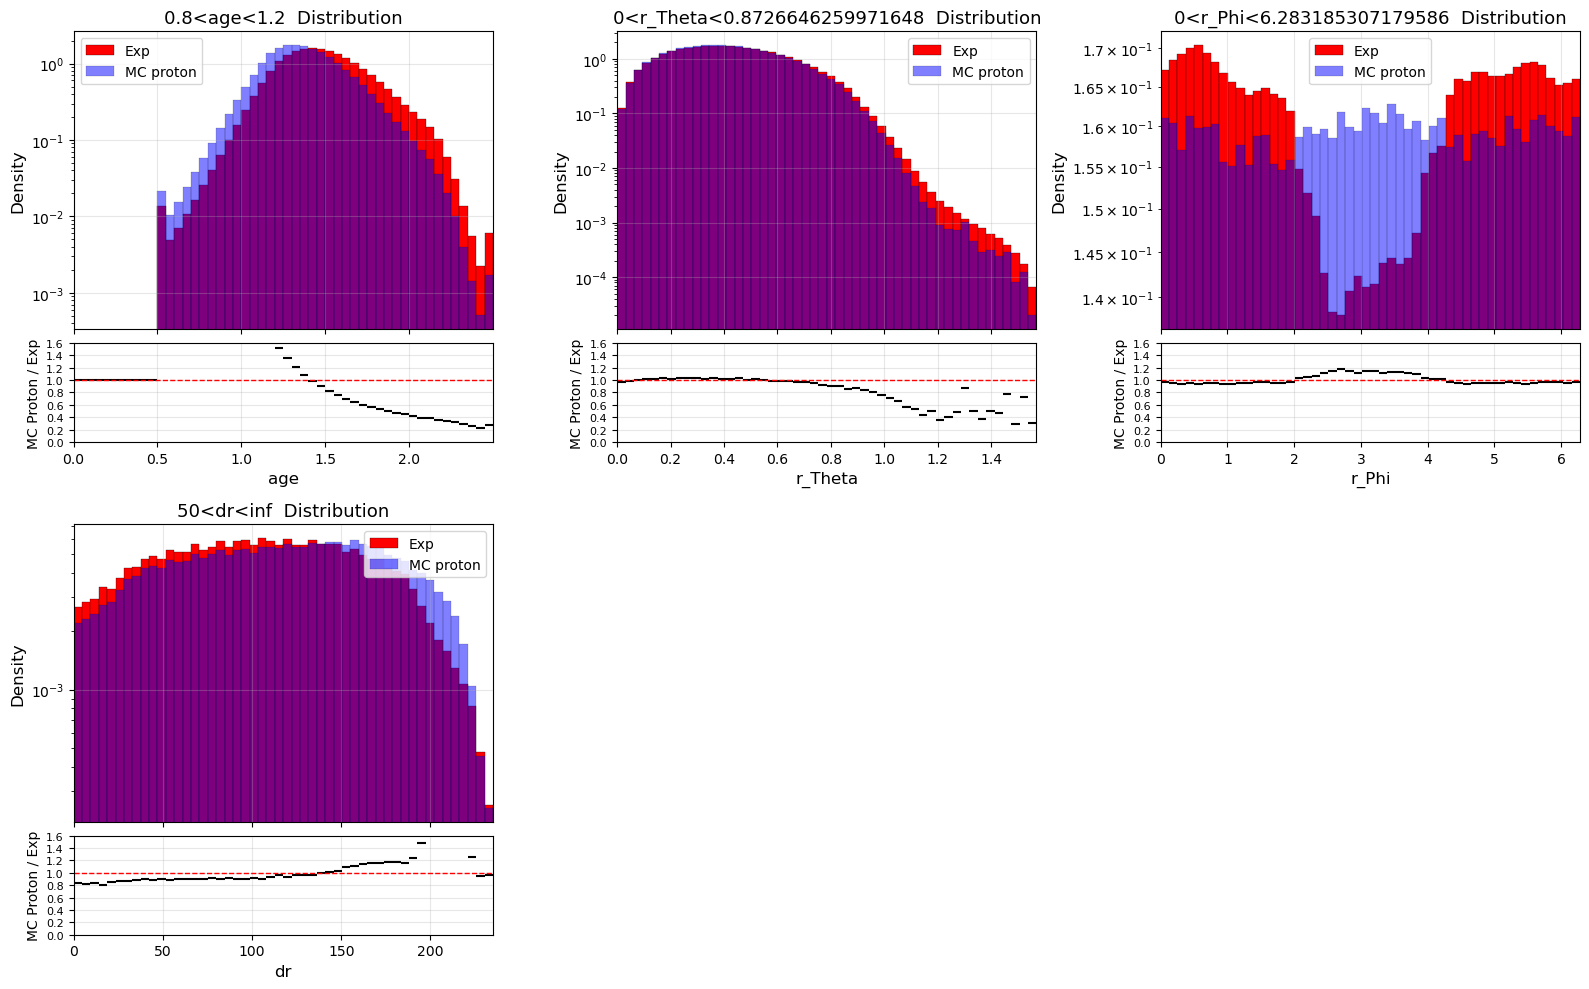

Reconstruction quality filter, left:
    Exp ratio 8.53110%
    MC  ratio 17.02414%
    MC-ExpAbs 8.49304%
dict_keys(['recE'])


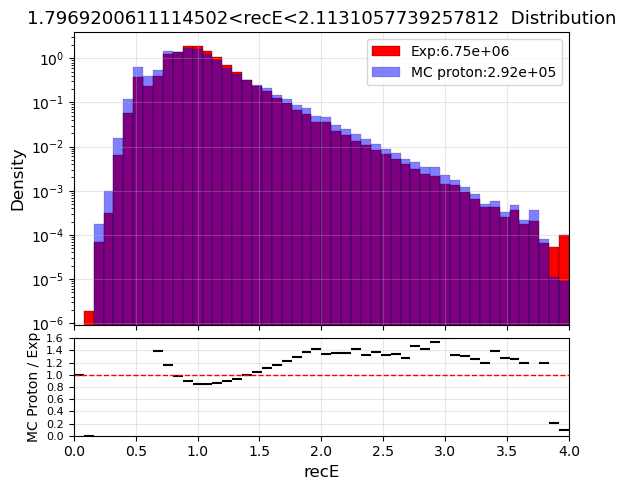

Rec Energy of XGBoost filter, left:
    Exp ratio 1.35221%
    MC  ratio 1.83965%
    MC-ExpAbs 0.48744%
dict_keys(['NhitE', 'NtrigE', 'NhitM', 'NpE1', 'NpE3', 'NuM1'])


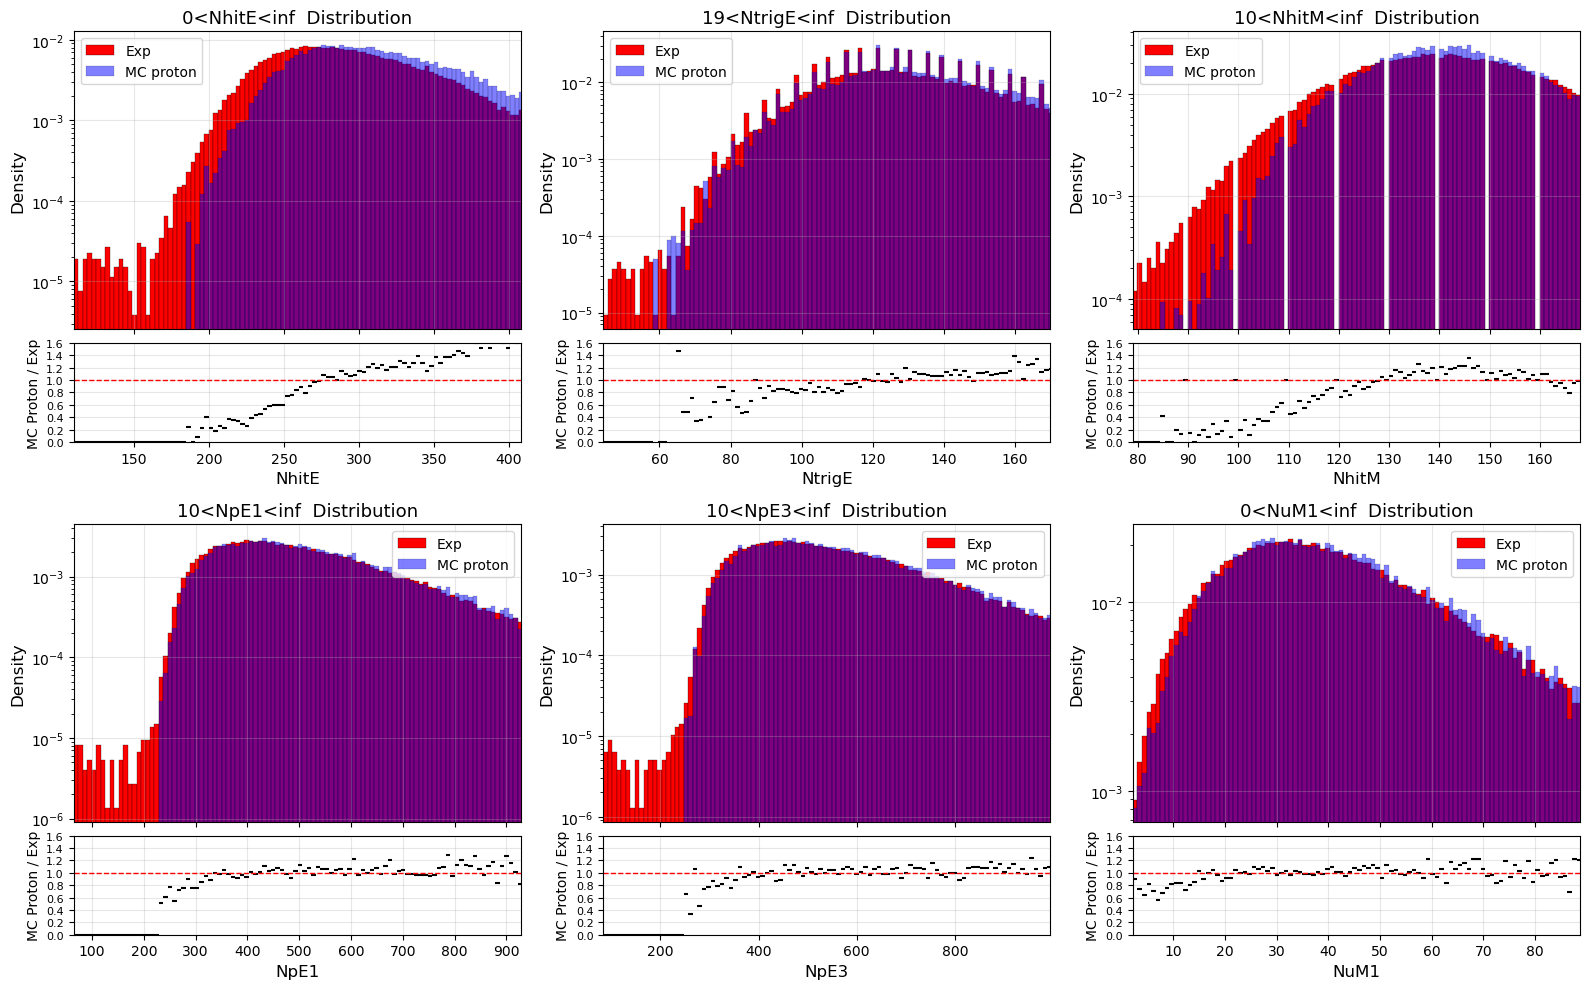

Basic quality filter, left:
    Exp ratio 99.95286%
    MC  ratio 100.00000%
    MC-ExpAbs 0.04714%
dict_keys(['R_ue'])


/home/zhonghua/miniconda3/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


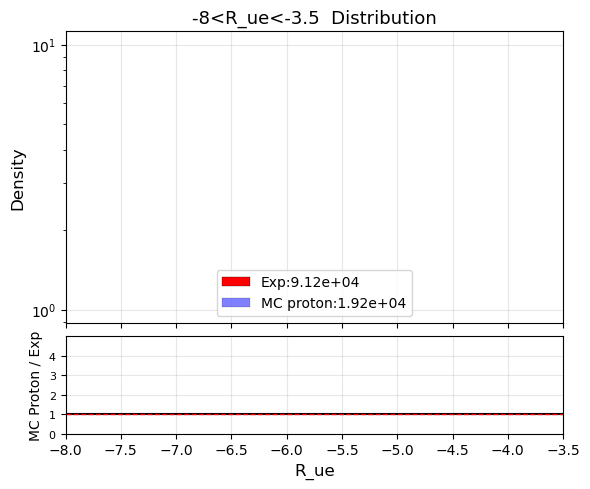

Muon (R_ue) filter, left:
    Exp ratio 0.00000%
    MC  ratio 0.00000%
    MC-ExpAbs 0.00000%


In [3]:
# step 1 filter

def plot_hist_basic(exp_df,mc_df,qualities_1, label="filterN"):
    n_params = len([param for param in qualities_1.keys() if param in exp_df.columns])
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols

    # 增加高度以容纳比例图 (例如，4:1的主图:比例图，总高度为5*n_rows)
    fig = plt.figure(figsize=(16, 5* n_rows))
    # 创建 n_rows x n_cols 的主网格
    main_gs = fig.add_gridspec(n_rows, n_cols, figure=fig)

    all_axes_main = []
    all_axes_ratio = []

    for i in range(n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
    
        # height_ratios=[3, 1] 表示主图占3/4，比例图占1/4
        # hspace=0 确保主图和比例图紧密相连
        sub_gs = main_gs[i].subgridspec(2, 1, height_ratios=[3, 1], hspace=0.07)
        
        ax_main = fig.add_subplot(sub_gs[0])
        ax_ratio = fig.add_subplot(sub_gs[1], sharex=ax_main)
        
        all_axes_main.append(ax_main)
        all_axes_ratio.append(ax_ratio)

    plot_idx = 0
    mc_over_exp_ratios = []
    bin_left_edges = []
    print(qualities_1.keys())
    for param, (min_val, max_val) in qualities_1.items():
        if param not in exp_df.columns:
            continue
        
        ax_main = all_axes_main[plot_idx]
        ax_ratio = all_axes_ratio[plot_idx]
        
        exp_param = exp_df[param]
        mc_param = mc_df[param]
        mc_weights = mc_df['weight'] if 'weight' in mc_df.columns else None
        
        exp_99 = np.percentile(exp_param, 90)
        mc_99 = np.percentile(mc_param, 90)
        exp_1 = np.percentile(exp_param, 0.1)
        mc_1 = np.percentile(mc_param, 0.1)
        data_range = (min(exp_1, mc_1), max(exp_99, mc_99))
        n_bins = int(data_range[1] - data_range[0])
        n_bins = 100


        bin_left_edges.append(np.linspace(data_range[0], data_range[1], n_bins + 1)[:-1])  # 保存bin的左边界
        exp_counts, bin_edges = np.histogram(exp_param, bins=n_bins, range=data_range, density=True)
        mc_counts, _ = np.histogram(mc_param, bins=n_bins, range=data_range, 
                weights=mc_weights, density=True)
        
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_width = bin_edges[1] - bin_edges[0]
        
        ax_main.hist(exp_param, bins=n_bins, alpha=1, density=True,  
            range=data_range, label='Exp', color='red',  
            edgecolor='black', linewidth=0.2)
        
        ax_main.hist(mc_param, bins=n_bins, alpha=0.5, density=True,
            range=data_range,
            weights=mc_weights,
            label='MC proton', color='blue',  
            edgecolor='black', linewidth=0.2)
        
        ax_main.set_ylabel('Density', fontsize=12)
        ax_main.set_yscale('log')
        ax_main.set_xlim((data_range[0], data_range[1]-2))
        ax_main.legend(fontsize=10)
        ax_main.grid(True, alpha=0.3)
        ax_main.set_title(f'{min_val}<{param}<{max_val}  Distribution', fontsize=13)
        plt.setp(ax_main.get_xticklabels(), visible=False)
        
        ratio = np.ones_like(mc_counts)
        mask_exp_gt_0 = exp_counts > 0
        ratio[mask_exp_gt_0] = mc_counts[mask_exp_gt_0] / exp_counts[mask_exp_gt_0]
        
        mask_exp_0_mc_gt_0 = (exp_counts == 0) & (mc_counts > 0)
        ratio[mask_exp_0_mc_gt_0] = np.nan
        # 保存 
        mc_over_exp_ratios.append(ratio)

        ax_ratio.errorbar(bin_centers, ratio, xerr=bin_width/2, fmt='.', ms=0, ls='none', 
            ecolor='black', elinewidth=1.5, capsize=0)
        
        ax_ratio.axhline(1, color='red', linestyle='--', linewidth=1)
        
        ax_ratio.set_xlabel(param, fontsize=12)
        ax_ratio.set_ylabel('MC Proton / Exp', fontsize=10)
        ax_ratio.grid(True, alpha=0.3)
        ax_ratio.set_ylim(0, 1.6)
        ax_ratio.set_yticks(np.arange(0, 1.8, 0.2))
        ax_ratio.tick_params(axis='y', labelsize=8)
        ax_ratio.set_xlim((data_range[0], data_range[1]-2))
        
        plot_idx += 1
    
    for j in range(plot_idx, n_rows * n_cols):
        all_axes_main[j].set_visible(False)
        all_axes_ratio[j].set_visible(False)
        
    plt.tight_layout()
    # 再次调整以确保子图间的 hspace 为 0
    fig.subplots_adjust(hspace=0.2) 
    plt.savefig(f"./figures/{label}.png", dpi=300)
    plt.show()
    # 保存为df,bin_left_edge为一列,mc_over..t
    N_weight = pd.DataFrame()

    for i in range(len(mc_over_exp_ratios)):
        col_name = str(list(qualities_1.keys())[i])
        
        # 使用pd.Series自动处理不同长度
        N_weight[col_name + "_bin_left_edge"] = pd.Series(bin_left_edges[i])
        N_weight[col_name] = pd.Series(mc_over_exp_ratios[i])
    N_weight.to_csv(f"./figures/{label}_weight.csv", index=False)

def plot_hist_rec(exp_df,mc_df,qualities_1, label="filterN"):
    n_params = len([param for param in qualities_1.keys() if param in exp_df.columns])
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols

    # 增加高度以容纳比例图 (例如，4:1的主图:比例图，总高度为5*n_rows)
    fig = plt.figure(figsize=(16, 5* n_rows))
    # 创建 n_rows x n_cols 的主网格
    main_gs = fig.add_gridspec(n_rows, n_cols, figure=fig)

    all_axes_main = []
    all_axes_ratio = []

    for i in range(n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
    
        # height_ratios=[3, 1] 表示主图占3/4，比例图占1/4
        # hspace=0 确保主图和比例图紧密相连
        sub_gs = main_gs[i].subgridspec(2, 1, height_ratios=[3, 1], hspace=0.07)
        
        ax_main = fig.add_subplot(sub_gs[0])
        ax_ratio = fig.add_subplot(sub_gs[1], sharex=ax_main)
        
        all_axes_main.append(ax_main)
        all_axes_ratio.append(ax_ratio)

    plot_idx = 0
    mc_over_exp_ratios = []
    bin_left_edges = []
    print(qualities_1.keys())
    for param, (min_val, max_val) in qualities_1.items():
        if param not in exp_df.columns:
            continue
        
        ax_main = all_axes_main[plot_idx]
        ax_ratio = all_axes_ratio[plot_idx]
        
        exp_param = exp_df[param]
        mc_param = mc_df[param]
        mc_weights = mc_df['weight'] if 'weight' in mc_df.columns else None
        
        exp_99 = np.percentile(exp_param, 100)
        mc_99 = np.percentile(mc_param, 100)
        data_range = (0, max(exp_99, mc_99))
        n_bins = 50


        bin_left_edges.append(np.linspace(data_range[0], data_range[1], n_bins + 1)[:-1])  # 保存bin的左边界
        exp_counts, bin_edges = np.histogram(exp_param, bins=n_bins, range=data_range, density=True)
        mc_counts, _ = np.histogram(mc_param, bins=n_bins, range=data_range, 
                weights=mc_weights, density=True)
        
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_width = bin_edges[1] - bin_edges[0]
        
        ax_main.hist(exp_param, bins=n_bins, alpha=1, density=True,  
            range=data_range, label='Exp', color='red',  
            edgecolor='black', linewidth=0.2)
        
        ax_main.hist(mc_param, bins=n_bins, alpha=0.5, density=True,
            range=data_range,
            weights=mc_weights,
            label='MC proton', color='blue',  
            edgecolor='black', linewidth=0.2)
        
        ax_main.set_ylabel('Density', fontsize=12)
        ax_main.set_yscale('log')
        ax_main.set_xlim((data_range[0], data_range[1]))
        ax_main.legend(fontsize=10)
        ax_main.grid(True, alpha=0.3)
        ax_main.set_title(f'{min_val}<{param}<{max_val}  Distribution', fontsize=13)
        plt.setp(ax_main.get_xticklabels(), visible=False)
        
        ratio = np.ones_like(mc_counts)
        mask_exp_gt_0 = exp_counts > 0
        ratio[mask_exp_gt_0] = mc_counts[mask_exp_gt_0] / exp_counts[mask_exp_gt_0]
        
        mask_exp_0_mc_gt_0 = (exp_counts == 0) & (mc_counts > 0)
        ratio[mask_exp_0_mc_gt_0] = np.nan
        # 保存 
        mc_over_exp_ratios.append(ratio)

        ax_ratio.errorbar(bin_centers, ratio, xerr=bin_width/2, fmt='.', ms=0, ls='none', 
            ecolor='black', elinewidth=1.5, capsize=0)
        
        ax_ratio.axhline(1, color='red', linestyle='--', linewidth=1)
        
        ax_ratio.set_xlabel(param, fontsize=12)
        ax_ratio.set_ylabel('MC Proton / Exp', fontsize=10)
        ax_ratio.grid(True, alpha=0.3)
        ax_ratio.set_ylim(0, 1.6)
        ax_ratio.set_yticks(np.arange(0, 1.8, 0.2))
        ax_ratio.tick_params(axis='y', labelsize=8)
        ax_ratio.set_xlim((data_range[0], data_range[1]))
        
        plot_idx += 1
    
    for j in range(plot_idx, n_rows * n_cols):
        all_axes_main[j].set_visible(False)
        all_axes_ratio[j].set_visible(False)
        
    plt.tight_layout()
    # 再次调整以确保子图间的 hspace 为 0
    fig.subplots_adjust(hspace=0.2) 
    plt.savefig(f"./figures/{label}.png", dpi=300)
    plt.show()
    # 保存为df,bin_left_edge为一列,mc_over..t
    N_weight = pd.DataFrame()

    for i in range(len(mc_over_exp_ratios)):
        col_name = str(list(qualities_1.keys())[i])
        
        # 使用pd.Series自动处理不同长度
        N_weight[col_name + "_bin_left_edge"] = pd.Series(bin_left_edges[i])
        N_weight[col_name] = pd.Series(mc_over_exp_ratios[i])
    N_weight.to_csv(f"./figures/{label}_weight.csv", index=False)

def plot_hist_recE(exp_df,mc_df,qualities_1,logTeV_range=(0,4), label="filterN"):
    n_params = len([param for param in qualities_1.keys() if param in exp_df.columns])
    n_cols = 1
    n_rows = 1

    # 增加高度以容纳比例图 (例如，4:1的主图:比例图，总高度为5*n_rows)
    fig = plt.figure(figsize=(6, 5* n_rows))
    # 创建 n_rows x n_cols 的主网格
    main_gs = fig.add_gridspec(n_rows, n_cols, figure=fig)

    all_axes_main = []
    all_axes_ratio = []

    for i in range(n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
    
        # height_ratios=[3, 1] 表示主图占3/4，比例图占1/4
        # hspace=0 确保主图和比例图紧密相连
        sub_gs = main_gs[i].subgridspec(2, 1, height_ratios=[3, 1], hspace=0.07)
        
        ax_main = fig.add_subplot(sub_gs[0])
        ax_ratio = fig.add_subplot(sub_gs[1], sharex=ax_main)
        
        all_axes_main.append(ax_main)
        all_axes_ratio.append(ax_ratio)

    plot_idx = 0
    mc_over_exp_ratios = []
    bin_left_edges = []
    print(qualities_1.keys())
    for param, (min_val, max_val) in qualities_1.items():
        if param not in exp_df.columns:
            continue
        
        ax_main = all_axes_main[plot_idx]
        ax_ratio = all_axes_ratio[plot_idx]
        
        exp_param = exp_df[param]
        mc_param = mc_df[param]
        mc_weights = mc_df['weight'] if 'weight' in mc_df.columns else None
        
        exp_99 = np.percentile(exp_param, 100)
        mc_99 = np.percentile(mc_param, 100)
        # data_range = (min_val-0.5, max_val+0.5)
        data_range = logTeV_range
        n_bins = 50


        bin_left_edges.append(np.linspace(data_range[0], data_range[1], n_bins + 1)[:-1])  # 保存bin的左边界
        exp_counts, bin_edges = np.histogram(exp_param, bins=n_bins, range=data_range, density=True)
        mc_counts, _ = np.histogram(mc_param, bins=n_bins, range=data_range, 
                weights=mc_weights, density=True)
        
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_width = bin_edges[1] - bin_edges[0]
        
        ax_main.hist(exp_param, bins=n_bins, alpha=1, density=True,  
            range=data_range, label=f'Exp:{len(exp_param):.2e}', color='red',  
            edgecolor='black', linewidth=0.2)
        
        ax_main.hist(mc_param, bins=n_bins, alpha=0.5, density=True,
            range=data_range,
            weights=mc_weights,
            label=f'MC proton:{len(mc_param):.2e}', color='blue',  
            edgecolor='black', linewidth=0.2)
        
        ax_main.set_ylabel('Density', fontsize=12)
        ax_main.set_yscale('log')
        ax_main.set_xlim((data_range[0], data_range[1]))
        ax_main.legend(fontsize=10)
        ax_main.grid(True, alpha=0.3)
        ax_main.set_title(f'{min_val}<{param}<{max_val}  Distribution', fontsize=13)
        plt.setp(ax_main.get_xticklabels(), visible=False)
        
        ratio = np.ones_like(mc_counts)
        mask_exp_gt_0 = exp_counts > 0
        ratio[mask_exp_gt_0] = mc_counts[mask_exp_gt_0] / exp_counts[mask_exp_gt_0]
        
        mask_exp_0_mc_gt_0 = (exp_counts == 0) & (mc_counts > 0)
        ratio[mask_exp_0_mc_gt_0] = np.nan
        # 保存 
        mc_over_exp_ratios.append(ratio)

        ax_ratio.errorbar(bin_centers, ratio, xerr=bin_width/2, fmt='.', ms=0, ls='none', 
            ecolor='black', elinewidth=1.5, capsize=0)
        
        ax_ratio.axhline(1, color='red', linestyle='--', linewidth=1)
        
        ax_ratio.set_xlabel(param, fontsize=12)
        ax_ratio.set_ylabel('MC Proton / Exp', fontsize=10)
        ax_ratio.grid(True, alpha=0.3)
        ax_ratio.set_ylim(0, 1.6)
        ax_ratio.set_yticks(np.arange(0, 1.8, 0.2))
        ax_ratio.tick_params(axis='y', labelsize=8)
        ax_ratio.set_xlim((data_range[0], data_range[1]))
        
        plot_idx += 1
    
    for j in range(plot_idx, n_rows * n_cols):
        all_axes_main[j].set_visible(False)
        all_axes_ratio[j].set_visible(False)
        
    plt.tight_layout()
    # 再次调整以确保子图间的 hspace 为 0
    fig.subplots_adjust(hspace=0.2) 
    plt.savefig(f"./figures/{label}.png", dpi=300)
    plt.show()
    # 保存为df,bin_left_edge为一列,mc_over..t
    N_weight = pd.DataFrame()

    for i in range(len(mc_over_exp_ratios)):
        col_name = str(list(qualities_1.keys())[i])
        
        # 使用pd.Series自动处理不同长度
        N_weight[col_name + "_bin_left_edge"] = pd.Series(bin_left_edges[i])
        N_weight[col_name] = pd.Series(mc_over_exp_ratios[i])
    N_weight.to_csv(f"./figures/{label}_weight.csv", index=False)
   
def plot_hist_muon(exp_df,mc_df,qualities_1,lessthan=-2.4, label="filterN"):
    n_params = len([param for param in qualities_1.keys() if param in exp_df.columns])
    n_cols = 1
    n_rows = 1

    # 增加高度以容纳比例图 (例如，4:1的主图:比例图，总高度为5*n_rows)
    fig = plt.figure(figsize=(6, 5* n_rows))
    # 创建 n_rows x n_cols 的主网格
    main_gs = fig.add_gridspec(n_rows, n_cols, figure=fig)

    all_axes_main = []
    all_axes_ratio = []

    for i in range(n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
    
        # height_ratios=[3, 1] 表示主图占3/4，比例图占1/4
        # hspace=0 确保主图和比例图紧密相连
        sub_gs = main_gs[i].subgridspec(2, 1, height_ratios=[3, 1], hspace=0.07)
        
        ax_main = fig.add_subplot(sub_gs[0])
        ax_ratio = fig.add_subplot(sub_gs[1], sharex=ax_main)
        
        all_axes_main.append(ax_main)
        all_axes_ratio.append(ax_ratio)

    plot_idx = 0
    mc_over_exp_ratios = []
    bin_left_edges = []
    print(qualities_1.keys())
    for param, (min_val, max_val) in qualities_1.items():
        if param not in exp_df.columns:
            continue
        
        ax_main = all_axes_main[plot_idx]
        ax_ratio = all_axes_ratio[plot_idx]
        
        exp_param = exp_df[param]
        mc_param = mc_df[param]
        mc_weights = mc_df['weight'] if 'weight' in mc_df.columns else None
        
        exp_99 = np.percentile(exp_param, 100)
        mc_99 = np.percentile(mc_param, 100)
        # data_range = (min_val-0.5, max_val+0.5)
        data_range = (min_val, lessthan)
        n_bins = 50


        bin_left_edges.append(np.linspace(data_range[0], data_range[1], n_bins + 1)[:-1])  # 保存bin的左边界
        exp_counts, bin_edges = np.histogram(exp_param, bins=n_bins, range=data_range, density=True)
        mc_counts, _ = np.histogram(mc_param, bins=n_bins, range=data_range, 
                weights=mc_weights, density=True)
        
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        bin_width = bin_edges[1] - bin_edges[0]
        
        ax_main.hist(exp_param, bins=n_bins, alpha=1, density=True,  
            range=data_range, label=f'Exp:{len(exp_param):.2e}', color='red',  
            edgecolor='black', linewidth=0.2)
        
        ax_main.hist(mc_param, bins=n_bins, alpha=0.5, density=True,
            range=data_range,
            weights=mc_weights,
            label=f'MC proton:{len(mc_param):.2e}', color='blue',  
            edgecolor='black', linewidth=0.2)
        
        ax_main.set_ylabel('Density', fontsize=12)
        ax_main.set_yscale('log')
        ax_main.set_xlim((data_range[0], data_range[1]))
        ax_main.legend(fontsize=10)
        ax_main.grid(True, alpha=0.3)
        ax_main.set_title(f'{min_val}<{param}<{max_val}  Distribution', fontsize=13)
        plt.setp(ax_main.get_xticklabels(), visible=False)
        
        ratio = np.ones_like(mc_counts)
        mask_exp_gt_0 = exp_counts > 0
        ratio[mask_exp_gt_0] = mc_counts[mask_exp_gt_0] / exp_counts[mask_exp_gt_0]
        
        mask_exp_0_mc_gt_0 = (exp_counts == 0) & (mc_counts > 0)
        ratio[mask_exp_0_mc_gt_0] = np.nan
        # 保存 
        mc_over_exp_ratios.append(ratio)

        ax_ratio.errorbar(bin_centers, ratio, xerr=bin_width/2, fmt='.', ms=0, ls='none', 
            ecolor='black', elinewidth=1.5, capsize=0)
        
        ax_ratio.axhline(1, color='red', linestyle='--', linewidth=1)
        
        ax_ratio.set_xlabel(param, fontsize=12)
        ax_ratio.set_ylabel('MC Proton / Exp', fontsize=10)
        ax_ratio.grid(True, alpha=0.3)
        ax_ratio.set_ylim(0, 5)
        ax_ratio.set_yticks(np.arange(0, 5, 1))
        ax_ratio.tick_params(axis='y', labelsize=8)
        ax_ratio.set_xlim((data_range[0], data_range[1]))
        
        plot_idx += 1
    
    for j in range(plot_idx, n_rows * n_cols):
        all_axes_main[j].set_visible(False)
        all_axes_ratio[j].set_visible(False)
        
    plt.tight_layout()
    # 再次调整以确保子图间的 hspace 为 0
    fig.subplots_adjust(hspace=0.2) 
    plt.savefig(f"./figures/{label}.png", dpi=300)
    plt.show()
    # 保存为df,bin_left_edge为一列,mc_over..t
    N_weight = pd.DataFrame()

    for i in range(len(mc_over_exp_ratios)):
        col_name = str(list(qualities_1.keys())[i])
        
        # 使用pd.Series自动处理不同长度
        N_weight[col_name + "_bin_left_edge"] = pd.Series(bin_left_edges[i])
        N_weight[col_name] = pd.Series(mc_over_exp_ratios[i])
    N_weight.to_csv(f"./figures/{label}_weight.csv", index=False)
   


def get_filter_mask(df, qualities_1):
        """为单个DataFrame生成过滤掩码"""
        mask = np.ones(len(df), dtype=bool)
        for param, (min_val, max_val) in qualities_1.items():
            if param in df.columns:
                param_mask = (df[param] > min_val) & (df[param] < max_val)
                mask &= param_mask
        
        return mask

def filter_basic(exp_df, mc_df):
    """根据质量参数过滤数据, 
    1: 'NhitE', 'NtrigE', 'NhitM', 
    返回indices"""
    qualities_1 = {
        "NhitE": (0, np.inf),  "NtrigE": (19, np.inf),"NhitM": (10, np.inf), 
        "NpE1": (10,np.inf), "NpE3": (10, np.inf),  "NuM1": (0, np.inf),

    }

    plot_hist_basic(exp_df=exp_df, mc_df=mc_df, qualities_1=qualities_1, label="basic_N")
    # 根据质量参数过滤数据, 且 NpE1/NpE2<2 得到indices

    exp_mask = get_filter_mask(exp_df, qualities_1)
    mc_mask = get_filter_mask(mc_df, qualities_1)
    
    exp_indices = exp_df.index[exp_mask]
    mc_indices = mc_df.index[mc_mask]
    exp_ratio = len(exp_indices) / len(exp_df)
    mc_ratio = np.sum(mc_df.loc[mc_indices, "weight"]) / np.sum(mc_df["weight"])
    mc_exp_ratio =mc_ratio-exp_ratio
    print(f"Basic quality filter, left:")
    print(f"    Exp ratio {exp_ratio:.5%}")
    print(f"    MC  ratio {mc_ratio:.5%}")
    print(f"    MC-ExpAbs {np.abs(mc_exp_ratio):.5%}")
    return exp_indices, mc_indices

def filter_rec_quality(exp_df, mc_df):
    """根据重建质量参数过滤数据, 
    1: "age", "r_Theta", "r_Phi", "r_Corex", "r_Corey", "dr"
    返回indices"""
    qualities = {
        "age": (0.8, 1.2), "r_Theta": (0, np.pi/180*50), "r_Phi": (0, 2*np.pi),
        "dr": (50, np.inf),
    }
    plot_hist_rec(exp_df=exp_df, mc_df=mc_df, qualities_1=qualities, label="rec_quality")
    exp_mask = get_filter_mask(exp_df, qualities)
    mc_mask = get_filter_mask(mc_df, qualities)
    
    exp_indices = exp_df.index[exp_mask]
    mc_indices = mc_df.index[mc_mask]
    # 乘以权重
    exp_ratio = len(exp_indices) / len(exp_df)
    mc_ratio = np.sum(mc_df.loc[mc_indices, "weight"]) / np.sum(mc_df["weight"])
    mc_exp_ratio =mc_ratio-exp_ratio
    print(f"Reconstruction quality filter, left:")
    print(f"    Exp ratio {exp_ratio:.5%}")
    print(f"    MC  ratio {mc_ratio:.5%}")
    print(f"    MC-ExpAbs {np.abs(mc_exp_ratio):.5%}")
    return exp_indices, mc_indices
    
def filter_recE(exp_df, mc_df):
    """根据重建质量参数过滤数据, 
    1: "recE"
    返回indices"""
    qualities = {
        "recE": (1.7969200611114502, 2.1131057739257812),
        # "recE": {1.5, 2.5}
    }
    
    plot_hist_recE(exp_df=exp_df, mc_df=mc_df, qualities_1=qualities, logTeV_range=(0,4), label="recE_XGBoost")
    exp_mask = get_filter_mask(exp_df, qualities)
    mc_mask = get_filter_mask(mc_df, qualities)
    
    exp_indices = exp_df.index[exp_mask]
    mc_indices = mc_df.index[mc_mask]
    exp_ratio = len(exp_indices) / len(exp_df)
    mc_ratio = np.sum(mc_df.loc[mc_indices, "weight"]) / np.sum(mc_df["weight"])
    mc_exp_ratio =mc_ratio-exp_ratio
    print(f"Rec Energy of XGBoost filter, left:")
    print(f"    Exp ratio {exp_ratio:.5%}")
    print(f"    MC  ratio {mc_ratio:.5%}")
    print(f"    MC-ExpAbs {np.abs(mc_exp_ratio):.5%}")
    return exp_indices, mc_indices

def filter_muon(exp_df, mc_df):
    lessthan = -3.5
    qualities = {
        "R_ue": (-8, lessthan)
    }
    plot_hist_muon(exp_df=exp_df, mc_df=mc_df, qualities_1=qualities, lessthan=lessthan, label="muon")
    exp_mask = get_filter_mask(exp_df, qualities)
    mc_mask = get_filter_mask(mc_df, qualities)
    
    exp_indices = exp_df.index[exp_mask]
    mc_indices = mc_df.index[mc_mask]
    exp_ratio = len(exp_indices) / len(exp_df)
    mc_ratio = np.sum(mc_df.loc[mc_indices, "weight"]) / np.sum(mc_df["weight"])
    mc_exp_ratio =mc_ratio-exp_ratio
    print(f"Muon (R_ue) filter, left:")
    print(f"    Exp ratio {exp_ratio:.5%}")
    print(f"    MC  ratio {mc_ratio:.5%}")
    print(f"    MC-ExpAbs {np.abs(mc_exp_ratio):.5%}")
    return exp_indices, mc_indices

# exp_indices, mc_indices = filter_basic(exp_df, mc_df)
# exp_df_basic = exp_df.loc[exp_indices]
# mc_df_basic = mc_df.loc[mc_indices]

# exp_indices, mc_indices = filter_rec_quality(exp_df_basic, mc_df_basic)
# exp_df_rec_quality = exp_df_basic.loc[exp_indices]
# mc_df_rec_quality = mc_df_basic.loc[mc_indices]

# exp_indices, mc_indices = filter_recE(exp_df_rec_quality, mc_df_rec_quality)
# exp_df_recE = exp_df_rec_quality.loc[exp_indices]
# mc_df_recE = mc_df_rec_quality.loc[mc_indices]

# exp_indices, mc_indices = filter_muon(exp_df_recE, mc_df_recE)
# exp_df_muon = exp_df_recE.loc[exp_indices]
# mc_df_muon = mc_df_recE.loc[mc_indices]


# 现进行recE的筛选-> basic ->rec -> muon

# exp_indices, mc_indices = filter_recE(exp_df, mc_df)
# exp_df_recE = exp_df.loc[exp_indices]
# mc_df_recE = mc_df.loc[mc_indices]

# exp_indices, mc_indices = filter_basic(exp_df_recE, mc_df_recE)
# exp_df_basic = exp_df_recE.loc[exp_indices]
# mc_df_basic = mc_df_recE.loc[mc_indices]

# exp_indices, mc_indices = filter_rec_quality(exp_df_basic, mc_df_basic)
# exp_df_rec_quality = exp_df_basic.loc[exp_indices]
# mc_df_rec_quality = mc_df_basic.loc[mc_indices]

# exp_indices, mc_indices = filter_muon(exp_df_rec_quality, mc_df_rec_quality)
# exp_df_muon = exp_df_rec_quality.loc[exp_indices]
# mc_df_muon = mc_df_rec_quality.loc[mc_indices]


# 现进行rec的筛选-> recE-> basic ->muon
exp_indices, mc_indices = filter_rec_quality(exp_df, mc_df)
exp_df_rec_quality = exp_df.loc[exp_indices]
mc_df_rec_quality = mc_df.loc[mc_indices]

exp_indices, mc_indices = filter_recE(exp_df_rec_quality, mc_df_rec_quality)
exp_df_recE = exp_df_rec_quality.loc[exp_indices]
mc_df_recE = mc_df_rec_quality.loc[mc_indices]

exp_indices, mc_indices = filter_basic(exp_df_recE, mc_df_recE)
exp_df_basic = exp_df_recE.loc[exp_indices]
mc_df_basic = mc_df_recE.loc[mc_indices]

exp_indices, mc_indices = filter_muon(exp_df_basic, mc_df_basic)
exp_df_muon = exp_df_basic.loc[exp_indices] 
mc_df_muon = mc_df_basic.loc[mc_indices]


